<a href="https://colab.research.google.com/github/indrajitrdas/RFM-Analysis-and-Clustering/blob/master/VividSeats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Importing Required Libraries

In [0]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# Reading Data

In [62]:
df = pd.read_excel('/content/gdrive/My Drive/Datasets/VividSeats/Order_Sample_Data2.xlsx', header = 0)
df_cluster = df
print(df.shape)
df.head(5)

(12005, 11)


,customerid,device,eventtype,league,orderdate,eventdate,customer_region,event_region,tickets,order_total,add_on_product_count
0,1,Device A,1,43,2015-07-23,2017-12-17,South,South,2,88.71,0
1,2,Device B,1,49,2015-05-13,2015-06-19,South,South,2,10.01,0
2,3,Device D,2,35,2015-09-01,2015-09-03,West,West,2,3.33,0
3,4,Device A,2,31,2015-10-06,2015-10-11,West,West,4,37.82,0
4,5,Device A,3,29,2015-12-24,2016-02-13,Northeast,Northeast,2,54.13,0


# **Exploratory Data Analysis**

In [4]:
# Identifying datatypes for each feature
df.dtypes

customerid                       int64
device                          object
eventtype                        int64
league                           int64
orderdate               datetime64[ns]
eventdate               datetime64[ns]
customer_region                 object
event_region                    object
tickets                          int64
order_total                    float64
add_on_product_count             int64
dtype: object

In [63]:
# Checking For Null Values
print(df.isnull().sum())

customerid              0
device                  0
eventtype               0
league                  0
orderdate               0
eventdate               0
customer_region         0
event_region            0
tickets                 0
order_total             0
add_on_product_count    0
dtype: int64


**Number of Uniques Values for each Feature**

In [64]:
# Function to count unique values for columns
def unique_counts(dataframe):
   for i in dataframe.columns:
       count = dataframe[i].nunique()
       print(i, ": ", count)
unique_counts(df)

customerid :  9999
device :  5
eventtype :  3
league :  55
orderdate :  365
eventdate :  627
customer_region :  6
event_region :  6
tickets :  20
order_total :  6123
add_on_product_count :  2


# Some Basic Groups of Customers

**1. People (n = 20) who bought most number of tickets**

In [83]:
n = 20
MostTickets = df.groupby('customerid').tickets.sum().nlargest(n).reset_index()
print(MostTickets.customerid)

0     1179
1     6882
2     9764
3     3276
4     8698
5     4998
6     5801
7     4636
8      294
9     2535
10    4992
11    1380
12    5301
13    9660
14     375
15    8432
16     795
17    3356
18    9335
19    2484
Name: customerid, dtype: int64


**2. People (n = 20) who bought most number of times**

In [98]:
MostFreq = df.groupby('customerid').customerid.count().nlargest(n).reset_index(name='count')
print(MostFreq.customerid)


0     5801
1     2535
2     1179
3     4130
4     2282
5     4992
6     8760
7     9660
8      638
9     1647
10    2385
11    4998
12    6146
13    9764
14     270
15     795
16    1380
17    1897
18    2104
19    2490
Name: customerid, dtype: int64


**3. People (n = 20) who spent most amout of money**

In [100]:
MostAmt = df.groupby('customerid').order_total.sum().nlargest(n).reset_index()
print(MostAmt.customerid)

0     2467
1     3704
2     9200
3     7075
4     9423
5     6146
6     6794
7     4087
8     3566
9     5852
10    7466
11    5136
12    2859
13    1835
14    3953
15    7307
16    9660
17    6594
18     643
19     795
Name: customerid, dtype: int64


# RFM (Recency, Frequency, Monetary) Analysis

In [101]:
# Checking First and Last timestamp for tickets
print(df['orderdate'].min())
print(df['orderdate'].max())

2015-01-01 00:00:00
2015-12-31 00:00:00


In [102]:
PRESENT = dt.datetime(2016,1,1)
df['orderdate'] = pd.to_datetime(df['orderdate'])
rfm= df.groupby('customerid').agg({'orderdate': lambda date: (PRESENT - date.max()).days,
                                   'customerid': lambda num: num.count(),
                                   'order_total': lambda price: price.sum()})
rfm.rename(columns={'orderdate': 'recency', 
                    'customerid': 'frequency', 
                    'order_total': 'monetary'}, inplace=True)
rfm.head(5)

,recency,frequency,monetary
customerid,,,
1,162,1,88.71
2,233,1,10.01
3,122,1,3.33
4,87,1,37.82
5,8,1,54.13


In [103]:
# Setting quantile scores
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
segmented_rfm = rfm.copy()

def Recency_Score(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def Frequency_Monetay_Score(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
      
segmented_rfm['r_score'] = segmented_rfm['recency'].apply(Recency_Score, args=('recency',quantiles,))
segmented_rfm['f_score'] = segmented_rfm['frequency'].apply(Frequency_Monetay_Score, args=('frequency',quantiles,))
segmented_rfm['m_score'] = segmented_rfm['monetary'].apply(Frequency_Monetay_Score, args=('monetary',quantiles,))
segmented_rfm['RFMScore'] = segmented_rfm.r_score.map(str) + segmented_rfm.f_score.map(str) + segmented_rfm.m_score.map(str)
segmented_rfm.head()

,recency,frequency,monetary,r_score,f_score,m_score,RFMScore
customerid,,,,,,,
1,162,1,88.71,3,4,1,341
2,233,1,10.01,3,4,4,344
3,122,1,3.33,2,4,4,244
4,87,1,37.82,2,4,3,243
5,8,1,54.13,1,4,2,142


**1. List of BEST customers**

In [109]:
# Best Customers
segmented_rfm[segmented_rfm['RFMScore']=='111'].reset_index().customerid

0        71
1       105
2       130
3       168
4       238
5       250
6       270
7       294
8       327
9       344
10      453
11      528
12      557
13      561
14      668
15      689
16      816
17      831
18      869
19      957
20      965
21      985
22      989
23      992
24     1015
25     1019
26     1071
27     1158
28     1169
29     1219
       ... 
263    9026
264    9058
265    9166
266    9173
267    9191
268    9200
269    9231
270    9280
271    9319
272    9471
273    9517
274    9585
275    9638
276    9645
277    9660
278    9684
279    9722
280    9764
281    9768
282    9806
283    9842
284    9848
285    9868
286    9869
287    9879
288    9900
289    9949
290    9952
291    9969
292    9997
Name: customerid, Length: 293, dtype: int64

**2. List of LOYAL Customers**

In [110]:
# Loyal Customers
segmented_rfm[segmented_rfm['RFMScore']=='414'].reset_index().customerid

0     1575
1     1996
2     2803
3     4112
4     4294
5     4479
6     4677
7     5032
8     5237
9     5543
10    6613
11    7824
12    8021
13    8462
14    8496
15    9096
16    9373
17    9620
18    9703
Name: customerid, dtype: int64

# **Cluster Analysis**

Used RFM table to create cluster using K-means. 

In [111]:
from sklearn import preprocessing
rfm_clusterAnalysis = segmented_rfm.filter(['recency','frequency','monetary'], axis =1)
scaler = preprocessing.MinMaxScaler()
scaled_rfm_clusterAnalysis = scaler.fit_transform(rfm_clusterAnalysis)
scaled_rfm_clusterAnalysis = pd.DataFrame(scaled_rfm_clusterAnalysis, columns=['recency','frequency', 'monetary'])
scaled_rfm_clusterAnalysis.head(5)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,recency,frequency,monetary
0,0.442308,0.0,0.033365
1,0.637363,0.0,0.003407
2,0.332418,0.0,0.000864
3,0.236264,0.0,0.013993
4,0.019231,0.0,0.020202


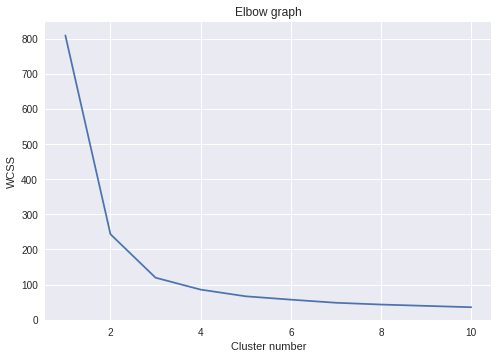

In [117]:
# Elbow graph to approximate number of clusters
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(scaled_rfm_clusterAnalysis)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

In [118]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(rfm_clusterAnalysis)
rfm_clusterAnalysis['clusters'] = clusters
rfm_clusterAnalysis.head()

,recency,frequency,monetary,clusters
customerid,,,,
1,162,1,88.71,1
2,233,1,10.01,0
3,122,1,3.33,1
4,87,1,37.82,1
5,8,1,54.13,1


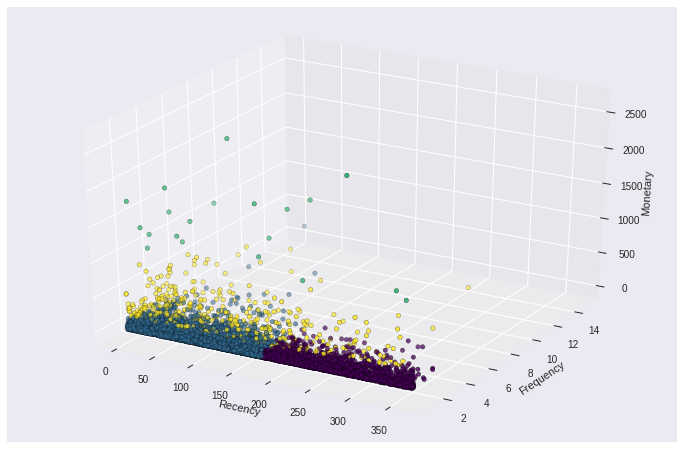

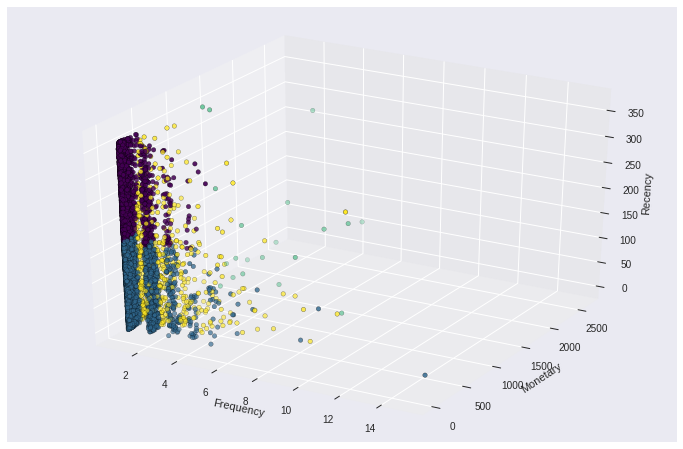

In [120]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
x = rfm_clusterAnalysis.recency
y = rfm_clusterAnalysis.frequency
z = rfm_clusterAnalysis.monetary
ax.scatter(x, y, z,  c=clusters, cmap='viridis',edgecolor='k',)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y, z, x,  c=clusters, cmap='viridis',edgecolor='k',)
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Recency')
plt.show()



In the above plot we see four clusters of customers based on Recency, Frequency and Monetary Value. Following could be an interpretation of the clusters
1. **Blue Cluster** : Most customers who are part of this cluster have made purchases less than two times, have spent less than five hundred dollars but have made their purchase(s) in the last six months.
2. **Purple Cluster**: The majority of this group has bought less than or equal to two times, have spent five hundred dollars or less and have not made purchase(s) in the last six months.
3. **Yellow Cluster**: This group is a bit scattered with the number of purchases ranging from 1 to 8. They have spent up to 1000 dollars and have purchased more in the last six months than before.
4. **Green Cluster**: The number of customers in this group are far fewer than the number of customers in the other groups. The maximum number of purchases of anyone in this group is seven.  The majority have bought event tickets in the last three months and have spent over $500.


# Future Work and Ideas

1. Further analysis could be done to exploit the relationships between customer region and event region.
2. Assuming peoples have an affinity towards specific event types and its details (example: Type-music concert, Details -Gojira) we can exploit these details and have a customoized model to select people who will have a high probability for wanting to purchase tickets. 
3. Customer type is an important factor that should be taken into consideration since a customer can be a regular person or an agency. For example - buying many tickets for one event Vs buying same number of tickets distributed through out multiple events can represent two different customer types.
4. Given more data(sales and online behavior) and a history of proven loyal customers, machine learning models could be designed to identify their similarity.
5. We can further look into the event and predict the demand of tickets and the pricing which can be directly fed to the customer segmentation model.
